In [5]:
import pickle
import spacy

In [6]:
%load_ext autoreload
%autoreload 2
import spacy
import scispacy
from scispacy.linking import EntityLinker
import en_core_sci_lg
from scify.nlp import *
from scify.utils.GNBR_preprocessing import get_data_and_distributions
#from spacy.language import Language


In [108]:
text = "Spinal and bulbar muscular atrophy (SBMA) is an inherited motor neuron disease caused by the expansion of a polyglutamine tract within the androgen receptor (AR). SBMA can be caused by this easily."

In [105]:
from scispacy.abbreviation import AbbreviationDetector
from spacy.pipeline import merge_entities
from scispacy.linking import EntityLinker

abbreviation_pipe = AbbreviationDetector(nlp)
nlp = spacy.load("en_core_sci_lg")

nlp.add_pipe(abbreviation_pipe)
nlp.add_pipe(merge_entities)
#nlp.add_pipe(linker_umls)

In [109]:
#linker_umls = EntityLinker(resolve_abbreviations=True, name="umls")
nlp.add_pipe(linker_umls)

ValueError: [E007] 'EntityLinker' already exists in pipeline. Existing names: ['tagger', 'parser', 'ner', 'AbbreviationDetector', 'merge_entities', 'EntityLinker']

In [266]:
from textacy.corpus import Corpus

corp = Corpus(nlp).load(nlp, "../data/experiments/pubmed_20n1015_annotated_756")

#https://github.com/explosion/spaCy/issues/860
#Doc.set_extension("annotated", default=None)
#doc = nlp(text)

In [267]:
from scify.consts import labels
for label in labels:
    nlp.vocab.strings.add(label)

In [259]:
#Doc.set_extension("annotated", default=False, force=False)
#Span.set_extension('annotated', default=[], force=True)
#Token.set_extension('annotated', default=[], force=False)
#corp[2].ents[1].set_extension('annotated', default=False, force=False)

In [271]:
def reannotate(doc:Doc):    
    """Takes deserialized doc.user_data and resets the ._.annotated attribute so it's easier to process later"""
    #strangely two entries with different spans for some entities in user_data as in ._.annotated although user_data is generated by ._.annotated 
    for k,v in doc.user_data.items():
        for ent in doc.ents:
            #print(k, v, k[2])
            if ent.start_char == k[2]:
                print(type(v), v)
                #converting to list to be consistent with merge_docs and other notebooks ._.annotated
                ent._.annotated = list(v)# if type(v) == tuple else []
                

In [272]:
def get_label_candidates_from_entity(ent: Span)->List:
    """aggregates labels from possibly multiple NER models (bc5, bionlpa...)"""
    

In [275]:
reannotate(corp[8])

<class 'tuple'> ({'idx': 0, 'kb_ents': (('C0000768', 1.0), ('C0302142', 1.0), ('C0018564', 0.8748171329498291), ('C0240547', 0.8733815550804138), ('C0575157', 0.8733180165290833)), 'label': 'DISEASE', 'model': 'umls', 'end_char': 509, 'start_char': 500},)
<class 'tuple'> ({'idx': 1, 'kb_ents': (('C0000768', 1.0), ('C0302142', 1.0), ('C0018564', 0.8748171329498291), ('C0240547', 0.8733815550804138), ('C0575157', 0.8733180165290833)), 'label': 'DISEASE', 'model': 'umls', 'end_char': 598, 'start_char': 589},)
<class 'tuple'> ({'idx': 2, 'kb_ents': (('C0000768', 1.0), ('C0302142', 1.0), ('C0018564', 0.8748171329498291), ('C0240547', 0.8733815550804138), ('C0575157', 0.8733180165290833)), 'label': 'DISEASE', 'model': 'umls', 'end_char': 763, 'start_char': 754},)
<class 'tuple'> ({'idx': 3, 'kb_ents': (('C0000768', 1.0), ('C0302142', 1.0), ('C0018564', 0.8748171329498291), ('C0240547', 0.8733815550804138), ('C0575157', 0.8733180165290833)), 'label': 'DISEASE', 'model': 'umls', 'end_char': 84

In [276]:
from scify.nlp import rgetattr, rsetattr
[rgetattr(ent, "_.annotated") for ent in corp[8].ents]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [{'idx': 0,
   'kb_ents': (),
   'label': 'MULTI-TISSUE_STRUCTURE',
   'model': 'umls',
   'end_char': 152,
   'start_char': 149}],
 [],
 [],
 [],
 [],
 [],
 [{'idx': 1,
   'kb_ents': (('C0030705', 1.0),
    ('C0025360', 0.8281130194664001),
    ('C0017313', 0.7970669865608215),
    ('C1550655', 0.7681549787521362),
    ('C1705908', 0.7681549787521362)),
   'label': 'ORGANISM',
   'model': 'umls',
   'end_char': 281,
   'start_char': 273}],
 [],
 [],
 [{'idx': 2,
   'kb_ents': (('C0030705', 1.0),
    ('C0025360', 0.8281130194664001),
    ('C0017313', 0.7970669865608215),
    ('C1550655', 0.7681549787521362),
    ('C1705908', 0.7681549787521362)),
   'label': 'ORGANISM',
   'model': 'umls',
   'end_char': 364,
   'start_char': 356}],
 [],
 [],
 [],
 [{'idx': 3,
   'kb_ents': (('C0030705', 1.0),
    ('C0025360', 0.8281130194664001),
    ('C0017313', 0.7970669865608215),
    ('C1550655', 0.7681549787521362),
    ('C1705908', 0.7681549787521362)),
   'la

In [270]:
corp[5].ents[10]._.annotated

[]

In [181]:
corp[6].user_data


{('._.',
  'annotated',
  118,
  128): ({'idx': 0,
   'kb_ents': (('C0027627', 1.0),
    ('C2939419', 1.0),
    ('C4255448', 1.0),
    ('C1708995', 0.9024338722229004),
    ('C0153690', 0.8949804902076721)),
   'label': 'DISEASE',
   'model': 'umls',
   'end_char': 128,
   'start_char': 118},),
 ('._.',
  'annotated',
  269,
  284): ({'idx': 1,
   'kb_ents': (('C0153690', 1.0),
    ('C0027627', 0.8949851393699646),
    ('C2939419', 0.8949851393699646),
    ('C1708995', 0.8384445905685425),
    ('C0684550', 0.818386971950531)),
   'label': 'DISEASE',
   'model': 'umls',
   'end_char': 284,
   'start_char': 269},),
 ('._.',
  'annotated',
  490,
  496): ({'idx': 2,
   'kb_ents': (('C0998265', 1.0),
    ('C0006826', 1.0),
    ('C2707253', 1.0),
    ('C1306459', 1.0),
    ('C1547140', 1.0)),
   'label': 'DISEASE',
   'model': 'umls',
   'end_char': 496,
   'start_char': 490},),
 ('._.',
  'annotated',
  689,
  696): ({'idx': 3,
   'kb_ents': (('C0015672', 0.9999998807907104),
    ('C455464

In [150]:
nlp.vocab, "spacy.vocab.Vocab at 0x232d1a54"

(<spacy.vocab.Vocab at 0x1cfdcd940>, 'spacy.vocab.Vocab at 0x232d1a54')

In [148]:
nlp.meta

{'lang': 'en',
 'name': 'core_sci_lg',
 'version': '0.2.5',
 'spacy_version': '>=2.3.0',
 'description': 'Spacy Models for Biomedical Text.',
 'author': 'Allen Institute for Artificial Intelligence',
 'email': 'ai2-info@allenai.org',
 'url': 'https://allenai.github.io/SciSpaCy/',
 'license': 'CC BY-SA 3.0',
 'vectors': {'width': 200,
  'vectors': 780000,
  'keys': 667880,
  'name': 'en_core_sci_lg_vectors'},
 'pipeline': ['tagger',
  'parser',
  'ner',
  'AbbreviationDetector',
  'merge_entities',
  'EntityLinker'],
 'factories': {'tagger': 'tagger',
  'parser': 'parser',
  'ner': 'ner',
  'AbbreviationDetector': 'AbbreviationDetector',
  'merge_entities': 'merge_entities',
  'EntityLinker': 'EntityLinker'},
 'labels': OrderedDict([('tagger',
               ['$',
                "''",
                ',',
                '-LRB-',
                '-RRB-',
                '.',
                ':',
                'ADD',
                'AFX',
                'CC',
                'CD',
 

In [ ]:
ent_idxs = [ent.start for ent in doc.ents]
non_ent_idxs = [token.i for token in doc if (token.ent_iob == 2 or token.ent_iob == 0)]


In [ ]:
sort(ent_idxs + non_ent_idx)


In [ ]:

spans =[]
ent_idxs = [ent.start for ent in doc.ents]
ents = doc.ents.copy()
for idx, token in enumerate(doc):
    if idx in ents_idxs:
        spans.append(doc[idx])
        
    


In [ ]:
[ent.start for ent in doc.ents],[token.i for token in doc if (token.ent_iob == 2 or token.ent_iob == 0)]


In [ ]:
[token.i for token in doc[:25] if token.ent_iob == 3],[token.i for token in doc[:25] if token.ent_iob != 2]

In [ ]:
#https://stackoverflow.com/questions/51412095/spacy-save-custom-pipeline

In [ ]:
nlp.meta

In [ ]:
from itertools import product

[* product(["Yolo", "Fredo", "checko"], ["fatty", "fagg"])]
tokens_lookup = {tok.text:tok for tok in doc}

In [ ]:
from spacy.tokens import Span
def semantic_spans_from_doc(doc):
    """Used for path analysis of depedency trees, where semantic units (entities) and not Tokens count. 
    
    Returns a list of all spans eg. [token, token, entitiy (spanning more tokens), token]
    This is so you can iterate through it under one span API
    
    iobs
    -3 begins
    -2 outside
    -1 inside
    -0 no tag of
    ...entity
    """
    "3 1 1"
    "3 2 3 1"
    "2 3 1"
    spans = []
    current_span = []
    for idx, token in enumerate(doc):
        iob = token.ent_iob
        if (iob != 1):
            spans.append(Span)
            current_span.append()
        
        
    return spans, doc

In [1]:
from scify.networks import get_edges

5

In [111]:
def last_token_of_entity(doc:Doc, token:Token)->Token:
    """Given a token in an entity, it recurses to the right until it finds a token where the IOB is not Inside (I)"""
    """ HMGB1-induced -> induced"""
    next_token = token.nbor()
    is_end = next_token.ent_iob != 1
    if is_end:
        return token
    else:
        return last_token_of_entity(doc, next_token)

In [112]:
#this might make trouble since it's a list of spans without the .DOC API methods?
spans = []
idx = 0
while idx < len(doc):
    print(idx, type(idx))
    token = doc[idx]
    if token.ent_iob == 3: #beginning of entity
        end_token = last_token_of_entity(doc, token)
        print(token,end_token)
        spans.append(doc[token.i : end_token.i + 1])
        idx = end_token.i + 1 #don't have an endless while loop
    else:
        idx = idx + 1
        spans.append(doc[token.i])

0 <class 'int'>
Spinal Spinal
1 <class 'int'>
2 <class 'int'>
bulbar muscular atrophy bulbar muscular atrophy
3 <class 'int'>
4 <class 'int'>
SBMA SBMA
5 <class 'int'>
6 <class 'int'>
7 <class 'int'>
8 <class 'int'>
inherited motor neuron disease
10 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
expansion expansion
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
polyglutamine tract polyglutamine tract
17 <class 'int'>
18 <class 'int'>
19 <class 'int'>
androgen receptor androgen receptor
20 <class 'int'>
21 <class 'int'>
AR AR
22 <class 'int'>
23 <class 'int'>
24 <class 'int'>
SBMA SBMA
25 <class 'int'>
26 <class 'int'>
27 <class 'int'>
28 <class 'int'>
29 <class 'int'>
30 <class 'int'>
31 <class 'int'>


In [130]:
doc[14].ent_iob
visualise_doc(doc, compact=True)

In [114]:
spans

[Spinal,
 and,
 bulbar muscular atrophy,
 (,
 SBMA,
 ),
 is,
 an,
 inherited motor neuron disease,
 caused,
 by,
 the,
 expansion,
 of,
 a,
 polyglutamine tract,
 within,
 the,
 androgen receptor,
 (,
 AR,
 ),
 .,
 SBMA,
 can,
 be,
 caused,
 by,
 this,
 easily,
 .]

In [123]:
import networkx as nx
from scify.networks import get_edges
from networkx.drawing.nx_agraph import graphviz_layout, 
import matplotlib.pyplot as plt

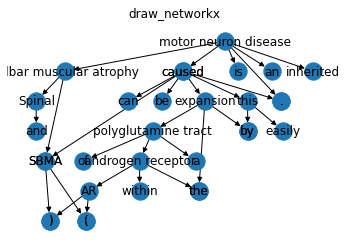

In [128]:
# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
G = nx.DiGraph(get_edges(doc))

nx.nx_agraph.write_dot(G,'test.dot')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
#plt.savefig('nx_test.png')

AttributeError: [E046] Can't retrieve unregistered extension attribute 'annotated'. Did you forget to call the `set_extension` method?

In [23]:
doc = nlp(text)
for token in doc:
    print(get_ent_from_token(token, doc))
    

[]
[]
[]
[study]
[study]
[]
[]
[]
[]
[agonist]
[]
[PPAR-γ]
[]
[]
[]
[]
[]
[inhibited]
[HMGB1-induced]
[EMT]
[]
[ECRSwNP]
[ECRSwNP]


In [27]:
doc.ents[2].

0

In [4]:
if (25 % 5 == 0): print(6)

6


In [ ]:
ent_idxs = [ent.start for ent in doc.ents]
non_ent_idxs = [token.i for token in doc if (token. == 2 or token.ent_iob == 0)]
all_spans:
for position in sort(ent_idxs + non_ent_idx):
    if(sorts[idx +1]):
        
    


In [22]:
def get_ent_from_token(token, doc):
    return [ent for ent in doc.ents if ent.start_char <= token.idx <= ent.end_char]

In [ ]:

spans =[]
ent_idxs = [ent.start for ent in doc.ents]
ents = doc.ents.copy()
for idx, token in enumerate(doc):
    if idx in ents_idxs:
        spans.append(doc[idx])
        
    


In [ ]:
def last_token_of_entity(doc:Doc, start_idx: int)->int:
    

In [ ]:
[ent.start for ent in doc.ents],[token.i for token in doc if (token.ent_iob == 2 or token.ent_iob == 0)]


In [ ]:
[token.i for token in doc[:25] if token.ent_iob == 3],[token.i for token in doc[:25] if token.ent_iob != 2]

In [ ]:
#valid pattern
construct_pattern('|appos|START_ENTITY sensitivity|nmod|END_ENTITY') or []

In [ ]:
#invalid pattern
construct_pattern('sensitivity|nmod|END_ENTITY sensitivity|appos|START_ENTITY')

In [ ]:
from scify.networks import get_edges

In [ ]:
def get_shortest_dep_path(ent_a, ent_b):
    #networkx

def pattern_from_shortest_dep_path():
    5
    
def extract_pattern_between_entities(doc, ent_a, ent_b):
    4
    
